In [3]:
#from ipywidgets import *
from fastai.vision import widgets
from fastbook import *

In [5]:
learn = load_learner('export.pkl')

In [6]:
uploader = widgets.FileUpload()
uploader

FileUpload(value=(), description='Upload')

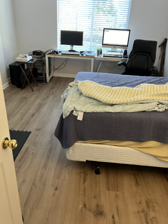

In [22]:
img = PILImage.create(uploader.value[0].content.tobytes())
img.to_thumb(224,224)

In [23]:
pred, pred_idx, probs = learn.predict(img)
pred, pred_idx, probs

('clean', tensor(0), tensor([0.9987, 0.0013]))

In [21]:
type(learn)

fastai.learner.Learner

# Export as CoreML

In [1]:
import torch
import torchvision
import coremltools as ct

scikit-learn version 1.5.0 is not supported. Minimum required version: 0.17. Maximum required version: 1.1.2. Disabling scikit-learn conversion API.
2024-05-29 00:15:37.514126: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-29 00:15:37.692488: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-29 00:15:37.692545: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-29 00:15:37.732660: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempti

In [14]:
# Set the model in evaluation mode.
learner = load_learner('export.pkl')
torch_model = learner.model
torch_model.eval()

# Trace the model with random data.
example_input = torch.rand(1, 3, 224, 224) 
traced_model = torch.jit.trace(torch_model, example_input)
out = traced_model(example_input)

In [15]:
# Set the image scale and bias for input image preprocessing.
scale = 1/(0.226*255.0)
bias = [- 0.485/(0.229) , - 0.456/(0.224), - 0.406/(0.225)]

image_input = ct.ImageType(name="input_1",
                           shape=example_input.shape,
                           scale=scale, bias=bias)

In [17]:
# Using image_input in the inputs parameter:
# Convert to Core ML program using the Unified Conversion API.
#model = ct.convert(
#    traced_model,
#    convert_to="mlprogram",
#    inputs=[ct.TensorType(shape=example_input.shape)]
#)

# Using image_input in the inputs parameter:
# Convert to Core ML using the Unified Conversion API.
model = ct.convert(
    traced_model,
    inputs=[image_input],
    classifier_config = ct.ClassifierConfig(['clean','messy']),
    compute_units=ct.ComputeUnit.ALL,
)

When both 'convert_to' and 'minimum_deployment_target' not specified, 'convert_to' is set to "mlprogram" and 'minimum_deployment_target' is set to ct.target.iOS15 (which is same as ct.target.macOS12). Note: the model will not run on systems older than iOS15/macOS12/watchOS8/tvOS15. In order to make your model run on older system, please set the 'minimum_deployment_target' to iOS14/iOS13. Details please see the link: https://apple.github.io/coremltools/docs-guides/source/target-conversion-formats.html
Running MIL backend_mlprogram pipeline: 100%|████████████████████████████████████████████| 12/12 [00:00<00:00, 386.30 passes/s]


In [18]:
# Save the converted model.
model.save("clean_or_messy.mlpackage")
# Print a confirmation message.
print('model converted and saved')

model converted and saved
